In [1]:
import pandas as pd
import numpy as np
import random
import cmath
import math
import sys
import matplotlib.pyplot as plt
from interval import interval
from interval import imath
from interval import fpu

def width(x_i):
    return sum([x.sup - x.inf for x in x_i])

def midpoint(x_i):
    return (x_i[0].sup + x_i[0].inf) / 2

def itos(x_i):
    return "{:9.7f} {:9.7f}".format(x_i[0].inf,x_i[0].sup)

In [2]:
def hansen(f,df,start,end,w,r,v,angle,ANS,tol=1e-7,iteration=1):   #hansen interval newton method 
    X = interval([start, end])
    X_width = width(X)

    # [Step 1]: Stop if no 0 in F(X)
    if 0 not in f(X,w,r,v,angle):
        #print(iteration, '-', itos(X), X_width, sep='\t')
        return

    # Return result if tolerance is satisfied
    if X_width < tol:
        #print(iteration, "+", itos(X), X_width, sep='\t')
        ANS.append((X[0].sup+X[0].inf)/2)
        return
    
    # [Step 2]: Half if 0 in F'(X)
    x_mid = midpoint(X)
    f_mid = float((f(x_mid,w,r,v,angle)[0].sup+f(x_mid,w,r,v,angle)[0].inf)/2)
    f_mid = f(x_mid,w,r,v,angle)
    df_X = df(X,w,r,v,angle)
    if f_mid == 0.0:
        #print(iteration, "++", itos(X), X_width, '<====== { f == 0 }', sep='\t')
        hansen(f, df, start, x_mid,w,r,v,angle,ANS, tol, iteration + 1)
        hansen(f, df, x_mid, end, w,r,v,angle,ANS, tol, iteration + 1)
        return
    
    # [Step 3]: Stop if X_next is empty
    U = x_mid - f_mid / df_X
    X_next = U & X
    if not X_next:
        #print(iteration, '-', itos(U) + '&' + itos(X), sep='\t')
        return

    # [Step 4]: Continue with narrowed intervals
    #print(iteration, "*", itos(X), X_width, sep='\t')
    [hansen(f, df, x.inf, x.sup, w,r,v,angle,ANS,tol, iteration + 1) for x in X_next]

In [3]:
def prehansen(f,df,start,end,w,r,v,angle,tol=1e-7,iteration=1): #对输入区间进行处理，并将结果输入到ANS中输出
    ANS=[]
    #if (start<0):
     #   start=0
    vv=float(np.dot(v,v))
    anglev=math.acos(v[0]/math.sqrt(vv))
    T = interval([start, end]) #求出func表达式中1/tan（）导致的奇点，从奇点处将区间分开求解
    T1 = angle+w*T-anglev   #用于得到tan里面分子的范围
    n = float(T1[0][0])//math.pi
    solarpoint=[]
    while ((n+1)*math.pi < float(T1[0][1])):    #如果在范围内有奇点
        solarpoint.append(((n+1)*math.pi+anglev-angle)/w)
        n+=1
    itvset=[]
    st = start
    if solarpoint:
        for sp in solarpoint:
            itvset.append(interval([st,sp]))
            st = sp
        itvset.append(interval([st,end]))
    else:
        itvset.append(interval([start,end]))
    for itv in itvset:
        #print('itv',itv[0])
        hansen(f, df,itv[0][0],itv[0][1], w,r,v,angle,ANS)
    ANS=list(filter(lambda x: 0<=x,ANS))
    
    if ANS:
        return min(ANS)
    else:
        return None
        

In [4]:
def ifunc(t,w,r,v,angle):    #碰撞方程 collision equation 
    v1=float(np.dot(v,r))
    vv=float(np.dot(v,v))
    v2=float(np.cross(v,r))
    anglev=cmath.polar(complex(v[0],v[1]))[1]
    return (v1-v2/imath.tan(angle+w*t-anglev))/vv-t
def difunc(t,w,r,v,angle): #碰撞方程导数
    vv=float(np.dot(v,v))
    v2=float(np.cross(v,r))
    anglev=cmath.polar(complex(v[0],v[1]))[1]
    return (w*v2/(imath.sin(angle+w*t-anglev)**2)/vv-1)
def intervalt2(t,w,r,v,angle):
    v1=float(np.dot(v,r))
    vv=float(np.dot(v,v))
    v2=float(np.cross(v,r))
    anglev=math.acos(v[0]/math.sqrt(vv))
    return (v1-v2/imath.tan(angle+w*t-anglev))/vv

In [133]:
#生成障碍点 generate barrier set
prebarrierset = [[random.random()*10-5 for j in range(1, 3)] for i in range(1,801)] 
barrierset=dict(zip(list(range(1,801)),prebarrierset))

In [ ]:
barrierset

In [ ]:
timeset=[]
timelim=99999
for i in range(1,2):
    #生成障碍点
    prebarrierset = [[random.random()*15-7.5 for j in range(1, 3)] for i in range(1,15*15*5)] 
    barrierset=dict(zip(list(range(1,15*15*5)),prebarrierset))
    #设置初始参数
    w=0          #杆转速
    ang=0                   #杆角度
    v=np.array([0.10355,0.25355]) #杆速度
    rr=np.array([0,0])    #杆位置
    m=1                     #杆质量
    L=2                     #杆长度
    postionset={}
    colset={}
    timec = 0
    for times in range(1,400):
        print(times)
        postionset[times]=[rr,ang]
        timeseries={}
        for no,bposition in barrierset.items():
            rb=np.array(bposition) #障碍点位置
            R=rb-rr
            B=float(np.matmul((R),-v))
            V2=float(np.matmul(v,v))
            R2=float(np.matmul(R,R))
            Q=B*B-V2*(R2-(L/2)*(L/2))
            if Q >=0: 
                T=np.array([-B/V2-math.sqrt(Q)/V2,-B/V2+math.sqrt(Q)/V2]) 
                ans=prehansen(ifunc,difunc,T[0],T[1],w,R,v,ang)        #求解碰撞时间序列，并且选择最小的T作为下次碰撞
                if ans:
                    timeseries[no]=ans
        if times == 1:
            result_min = min(timeseries, key=lambda x:timeseries[x])
        else:
            if result_min == min(timeseries, key=lambda x:timeseries[x]):
                timeseries.pop(result_min)
                result_min = min(timeseries, key=lambda x:timeseries[x])
            else:
                result_min = min(timeseries, key=lambda x:timeseries[x])
        timec += timeseries[result_min]
        colset[times]=[result_min,timec]
        timeset.append(timec)
        print(timec)
        if timec >=timelim:
            break

        #碰撞计算
        r_collision = rr+v*timeseries[result_min]
        r_barrier = barrierset[result_min]
        ang_collision= ang+w*timeseries[result_min]
        deltr=r_collision-r_barrier
        ephi=np.array([math.cos(ang_collision),math.sin(ang_collision)])
        eperp=np.array([-math.sin(ang_collision),math.cos(ang_collision)])
        a=-np.dot(deltr,ephi)
        I=1/3*m*(L/2)**2
        deltp=2*m*I*(np.cross(v,ephi)-w*a)/(I+m*a**2)

        vfinal=v+eperp*deltp/m   #算得碰撞后参数，并且更新
        wfinal=w+a*deltp/I

        ang=ang+w*timeseries[result_min]
        v=vfinal
        w=float(wfinal)
        rr=r_collision



In [4]:
def mainfuc(N,L,w,v1):     #初始        
    timeset=[]
    for i in range(1,601):
        #生成障碍点
        prebarrierset = [[random.random()*20-10 for j in range(1, 3)] for i in range(1,20*20*N*1)] 
        barrierset=dict(zip(list(range(1,20*20*N+1)),prebarrierset))
        ang=0                    #杆角度
        v=np.array([0,v1])       #杆速度
        rr=np.array([-1,-1])    #杆位置
        m=1                     #杆质量
        postionset={}
        colset={}
        timec = 0
        for times in range(1,2):
            postionset[times]=[rr,ang]
            timeseries={}
            for no,bposition in barrierset.items():
                rb=np.array(bposition) #障碍点位置
                R=rb-rr
                B=float(np.matmul((R),-v))
                V2=float(np.matmul(v,v))
                R2=float(np.matmul(R,R))
                Q=B*B-V2*(R2-(L/2)*(L/2))
                if Q >=0: 
                    T=np.array([-B/V2-math.sqrt(Q)/V2,-B/V2+math.sqrt(Q)/V2]) 
                    ans=prehansen(ifunc,difunc,T[0],T[1],w,R,v,ang)        #求解碰撞时间序列，并且选择最小的T作为下次碰撞
                    if ans:
                        timeseries[no]=ans
            if not timeseries:
                print('error:no collision')
                return
            if times == 1:
                result_min = min(timeseries, key=lambda x:timeseries[x])
            else:
                if result_min == min(timeseries, key=lambda x:timeseries[x]):
                    timeseries.pop(result_min)
                    result_min = min(timeseries, key=lambda x:timeseries[x])
                else:
                    result_min = min(timeseries, key=lambda x:timeseries[x])
            timec += timeseries[result_min]
            colset[times]=[result_min,timec]
            timeset.append(timec)

            #碰撞计算
            r_collision = rr+v*timeseries[result_min]
            r_barrier = barrierset[result_min]
            ang_collision= ang+w*timeseries[result_min]
            deltr=r_collision-r_barrier
            ephi=np.array([math.cos(ang_collision),math.sin(ang_collision)])
            eperp=np.array([-math.sin(ang_collision),math.cos(ang_collision)])
            a=-np.dot(deltr,ephi)
            I=1/3*m*(L/2)**2
            deltp=2*m*I*(np.cross(v,ephi)-w*a)/(I+m*a**2)

            vfinal=v+eperp*deltp/m   #算得碰撞后参数，并且更新
            wfinal=w+a*deltp/I

            ang=ang+w*timeseries[result_min]
            v=vfinal
            w=float(wfinal)
            rr=r_collision
    print(np.mean(timeset))
    return 0


In [5]:
def mainfucjun(N,L,w,v1):             #均方根
    timeset=[]
    for i in range(1,601):
        #生成障碍点
        prebarrierset = [[random.random()*20-10 for j in range(1, 3)] for i in range(1,20*20*N*1)] 
        barrierset=dict(zip(list(range(1,20*20*N+1)),prebarrierset))
        #设置初始参数          #杆转速
        ang=0                   #杆角度
        ang1=random.random()*2*math.pi
        if ang1 < 0.05:
            ang1=0.05
        if (ang1 < 3.19) & (ang1 > 3.09):
            ang1=3.09
        if ang1 > 6.23318:
            ang1=6.18318
        v=np.array([v1*math.cos(ang1),v1*math.sin(ang1)])     #杆速度
        rr=np.array([0,0])    #杆位置
        m=1                     #杆质量                     
        postionset={}
        colset={}
        timec = 0
        for times in range(1,2):
            postionset[times]=[rr,ang]
            timeseries={}
            for no,bposition in barrierset.items():
                rb=np.array(bposition) #障碍点位置
                R=rb-rr
                B=float(np.matmul((R),-v))
                V2=float(np.matmul(v,v))
                R2=float(np.matmul(R,R))
                Q=B*B-V2*(R2-(L/2)*(L/2))
                if Q >=0: 
                    T=np.array([-B/V2-math.sqrt(Q)/V2,-B/V2+math.sqrt(Q)/V2]) 
                    ans=prehansen(ifunc,difunc,T[0],T[1],w,R,v,ang)        #求解碰撞时间序列，并且选择最小的T作为下次碰撞
                    if ans:
                        timeseries[no]=ans
            if not timeseries:
                print('error:no collision')
                return
            if times == 1:
                result_min = min(timeseries, key=lambda x:timeseries[x])
            else:
                if result_min == min(timeseries, key=lambda x:timeseries[x]):
                    timeseries.pop(result_min)
                    result_min = min(timeseries, key=lambda x:timeseries[x])
                else:
                    result_min = min(timeseries, key=lambda x:timeseries[x])
            timec += timeseries[result_min]
            colset[times]=[result_min,timec]
            timeset.append(timec)

            #碰撞计算
            r_collision = rr+v*timeseries[result_min]
            r_barrier = barrierset[result_min]
            ang_collision= ang+w*timeseries[result_min]
            deltr=r_collision-r_barrier
            ephi=np.array([math.cos(ang_collision),math.sin(ang_collision)])
            eperp=np.array([-math.sin(ang_collision),math.cos(ang_collision)])
            a=-np.dot(deltr,ephi)
            I=1/3*m*(L/2)**2
            deltp=2*m*I*(np.cross(v,ephi)-w*a)/(I+m*a**2)

            vfinal=v+eperp*deltp/m   #算得碰撞后参数，并且更新
            wfinal=w+a*deltp/I

            ang=ang+w*timeseries[result_min]
            v=vfinal
            w=float(wfinal)
            rr=r_collision
    print(np.mean(timeset))
    return 0


In [6]:
def m1(a): 
    for i in range(1,10):
        print(a)
        if a >10:
            return
    return

In [26]:
def mainfucjunt(N,L,w,v1,timelimit,timeset):             #均方根t的计算
    for i in range(1,2):
        #生成障碍点
        prebarrierset = [[random.random()*15-7.5 for j in range(1, 3)] for i in range(1,15*15*N*1)] 
        barrierset=dict(zip(list(range(1,15*15*N+1)),prebarrierset))
        #设置初始参数          #杆转速
        ang=0                   #杆角度
        ang1=random.random()*2*math.pi
        if ang1 < 0.05:
            ang1=0.05
        if (ang1 < 3.19) & (ang1 > 3.09):
            ang1=3.09
        if ang1 > 6.23318:
            ang1=6.18318
        v=np.array([v1*math.cos(ang1),v1*math.sin(ang1)])     #杆速度
        rr=np.array([0,0])    #杆位置
        m=1                     #杆质量                     
        postionset={}
        colset={}
        timec = 0
        for times in range(1,1501):
            if times == 1500:
                print('error! times=600,',N,L)
            postionset[times]=[rr,ang]
            timeseries={}
            for no,bposition in barrierset.items():
                rb=np.array(bposition) #障碍点位置
                R=rb-rr
                B=float(np.matmul((R),-v))
                V2=float(np.matmul(v,v))
                R2=float(np.matmul(R,R))
                Q=B*B-V2*(R2-(L/2)*(L/2))
                if Q >=0: 
                    T=np.array([-B/V2-math.sqrt(Q)/V2,-B/V2+math.sqrt(Q)/V2]) 
                    ans=prehansen(ifunc,difunc,T[0],T[1],w,R,v,ang)        #求解碰撞时间序列，并且选择最小的T作为下次碰撞
                    if ans:
                        timeseries[no]=ans
            if not timeseries:
                print('error:no collision')
                return 1
            if times == 1:
                result_min = min(timeseries, key=lambda x:timeseries[x])
            else:
                if result_min == min(timeseries, key=lambda x:timeseries[x]):
                    timeseries.pop(result_min)
                    result_min = min(timeseries, key=lambda x:timeseries[x])
                else:
                    result_min = min(timeseries, key=lambda x:timeseries[x])
            timec += timeseries[result_min]
            colset[times]=[result_min,timec]
            timeset.append([w,timec,v])
            if timec >=timelimit:            #如果时间满足了则跳出循环
                #print('break at',times)
                return 0
            #碰撞计算
            r_collision = rr+v*timeseries[result_min]
            r_barrier = barrierset[result_min]
            ang_collision= ang+w*timeseries[result_min]
            deltr=r_collision-r_barrier
            ephi=np.array([math.cos(ang_collision),math.sin(ang_collision)])
            eperp=np.array([-math.sin(ang_collision),math.cos(ang_collision)])
            a=-np.dot(deltr,ephi)
            I=1/3*m*(L/2)**2
            deltp=2*m*I*(np.cross(v,ephi)-w*a)/(I+m*a**2)

            vfinal=v+eperp*deltp/m   #算得碰撞后参数，并且更新
            wfinal=w+a*deltp/I

            ang=ang+w*timeseries[result_min]
            v=vfinal
            w=float(wfinal)
            rr=r_collision
    return 0


In [21]:
def caldrot(N,L,w,v1,tlim):
    angledpmsum=np.array([])
    for i in range(1,81):
        print(i)
        tt=[]
        xxx=mainfucjunt(N,L,w,v1,tlim,tt)
        if xxx==1:
            print ('++++++++++error,',N,L)
        else:
            angledpm=np.array([])
            for j in range(0,tlim*50+1):
                angledpm=np.append(angledpm,calt(tt,j/50))
            if angledpmsum.size ==0:
                angledpmsum=angledpm
            else:
                angledpmsum=np.vstack((angledpmsum,angledpm))
    print('!!!!!!!!!!over!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    return(np.mean(angledpmsum,axis=0))


In [7]:
def caldeff(N,L,w,v1,tlim):
    angledpmsum=np.array([])
    for i in range(1,31):
        print(i)
        tt=[]
        xxx=mainfucjunt(N,L,w,v1,tlim,tt)
        if xxx==1:
            print ('++++++++++error,',N,L)
        else:
            angledpm=np.array([])
            for j in range(0,tlim*2+1):
                angledpm=np.append(angledpm,calt(tt,j/2))
            if angledpmsum.size ==0:
                angledpmsum=angledpm
            else:
                angledpmsum=np.vstack((angledpmsum,angledpm))
    print('!!!!!!!!!!over!!!!!!!!!!!!!!')
    return(np.mean(angledpmsum,axis=0))

In [ ]:
n1=caldrot(9,4,0.5,2,4)

In [276]:
a=np.array([])
a=np.append(a,1)
a=np.append(a,2)
b=np.array([])
b=np.append(b,3)
b=np.append(b,4)
n=caldrot(3,2,0,0.5,12)
2=caldrot(4,2,0,0.5,12)
n=caldrot(6,2,0,0.5,12)
n=caldrot(6,3,0,0.5,12)
5=caldrot(6,4,0,0.5,10)
6=caldrot(7,5,0,0.5,10)
n7=caldrot(7,6,0,0.5,8)
n8=caldrot(7,7,0,0.5,8)

In [308]:
a=np.array([-0.41502142,0.27884981])
b=np.array([-0.41502142,0.13316025])
c=np.array([-0.37722485,-0.32166623])
d=np.array([-0.38053772,-0.22233053])
e=a*0.32086333018611846+b*(0.5162438333942654-0.32086333018611846)+c*(0.9561861091044036-0.5162438333942654)+d*(1-0.9561861091044036)

In [ ]:
math.sqrt(e[1]**2+e[0]**2)

In [ ]:
angledpm=[]
for i in range(0,20):
    angledpm.append(calt(tt,i))
angledpm

In [ ]:
calt(tt,1)

In [24]:
def calt(tt,t):
    index = -1
    w2=0
    for i in range(len(tt)-1):
        if (t>= tt[i][1]) & (t< tt[i+1][1]):
            index = i
    if t< tt[0][1]:
        index=-2
        w2 += tt[0][0]*t
        return w2
    if index == -1:
        print('error:t is too small/large')
        return 
    for i in range(index+1):
        if (index == 0):
            w2 += tt[0][0]*tt[0][1]+tt[1][0]*(t-tt[0][1])
        elif (i == 0):
            w2 += tt[0][0]*tt[0][1]
        else:
            w2+=tt[i][0]*(tt[i][1]-tt[i-1][1])
            if (i == index):
                w2 += tt[i+1][0]*(t-tt[i][1])
    return w2**2

In [25]:
def calr(tt,t):
    index = -1
    w2=[0,0]
    for i in range(len(tt)-1):
        if (t>= tt[i][1]) & (t< tt[i+1][1]):
            index = i
    if t< tt[0][1]:
        index=-2
        w2 += tt[0][2]*t
        return w2
    if index == -1:
        print('error:t is too small/large')
        return 
    for i in range(index+1):
        if (index == 0):
            w2 += tt[0][2]*tt[0][1]+tt[1][2]*(t-tt[0][1])
        elif (i == 0):
            w2 += tt[0][2]*tt[0][1]
        else:
            w2+=tt[i][2]*(tt[i][1]-tt[i-1][1])
            if (i == index):
                w2 += tt[i+1][2]*(t-tt[i][1])
    return math.sqrt(w2[0]**2+w2[1]**2)

In [ ]:
b=np.array([1,2])
c=[1,2]
b+c

In [ ]:
mainfuc(5,0.5,math.atan(0.5),0.5)
mainfuc(5,1,math.atan(0.5),0.5)
mainfuc(5,3,math.atan(0.5),0.5)
mainfuc(5,4,math.atan(0.5),0.5)

In [ ]:
mainfuc(5,2.5,math.atan(0.5),0.5)

In [11]:
rodseta=[]
rodsetb=[]
for xx,yy in postionset.items():
    rodseta.append((yy[0]+L/2*np.array([math.cos(yy[1]),math.sin(yy[1])])).tolist())
    rodsetb.append((yy[0]-L/2*np.array([math.cos(yy[1]),math.sin(yy[1])])).tolist())

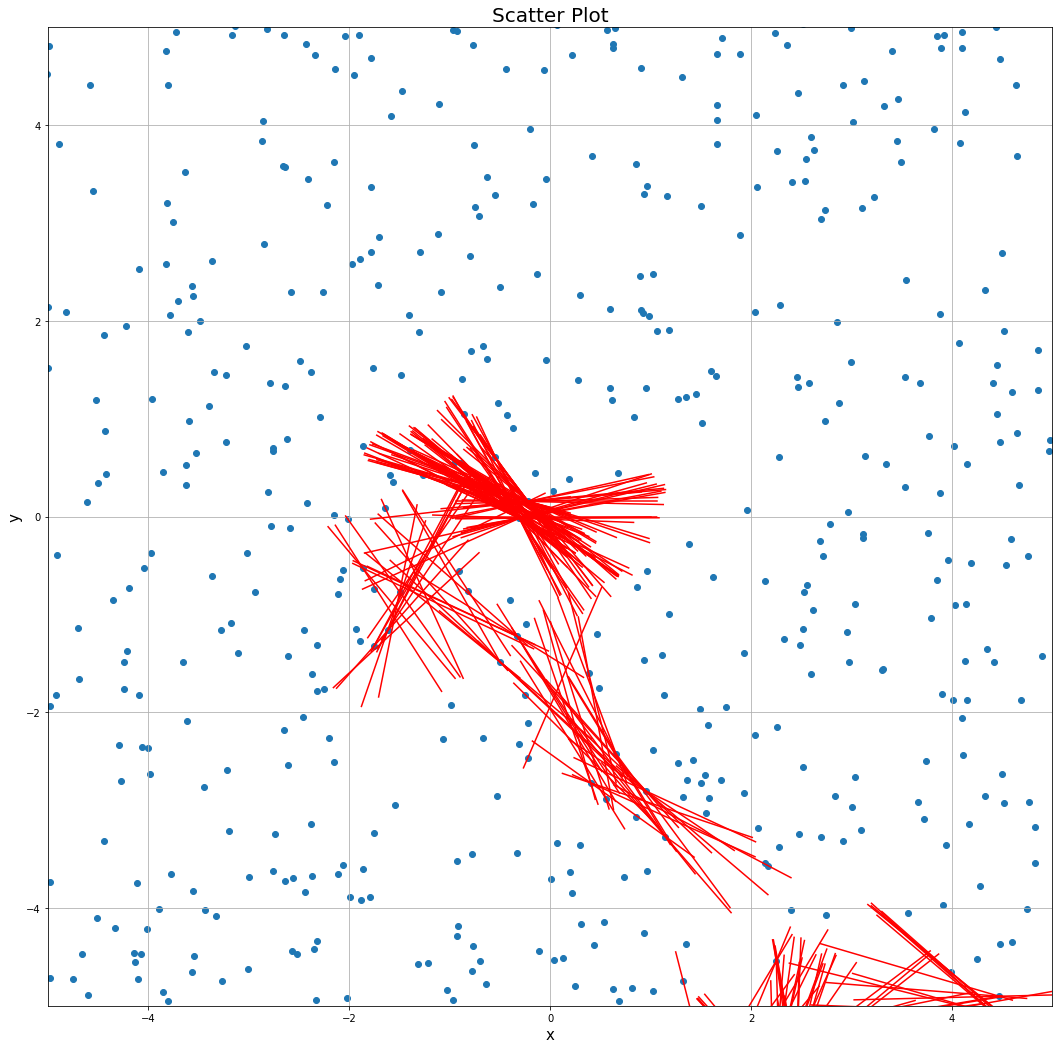

In [12]:
#画图
data = {"x":[], "y":[], "label":[]}
for label, coord in barrierset.items():
    data["x"].append(coord[0])
    data["y"].append(coord[1])


# display scatter plot data
plt.figure(figsize=(18,18))
plt.title('Scatter Plot', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.ylim((-5,5))
plt.xlim((-5,5))
plt.scatter(data["x"], data["y"], marker = 'o')
plt.grid()
for left, right in zip(rodseta, rodsetb):
    plt.plot( [left[0],right[0]], [left[1],right[1]], 'r')
# add labels
for label, x, y in zip(data["label"], data["x"], data["y"]):
    plt.annotate(label, xy = (x, y))
    

In [ ]:
i=0.5
ii=0
iii=[]
iiii=[]

while (i <3.5):
    print("df=",difunc(i,math.atan(1),R,v,0))
    iii.append(ifunc(i,math.atan(1),R,v,0))
    iiii.append(i)
    i+=0.0001
    ii+=1

In [ ]:
import matplotlib.pyplot as plt
plt.figure()    # 定义一个图像窗口
plt.ylim(-10,10)
plt.plot(iiii,iii) # 绘制曲线 y1
plt.show()

In [ ]:
i=0
ii=0
iii=[]
iiii=[]

while (i <0.1):
    iii.append(ifunc(i,w,R,v,ang)[0][0])
    iiii.append(i)
    i+=0.000001
    ii+=1


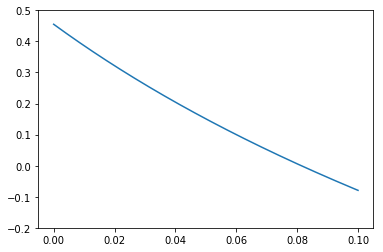

In [300]:
import matplotlib.pyplot as plt
plt.figure()    # 定义一个图像窗口
plt.ylim(-0.2,0.5)
plt.plot(iiii,iii) # 绘制曲线 y1
plt.show()

In [296]:
ifunc(0.08133971789864927,w,R,v,ang)

v1= -1.6827636110229751 vv= 1.7614953671195726 v2= 0.5319249445462266 anglev= 0.3699683521332111


interval([1.6452640694275544e-08, 1.645264111060918e-08])

In [ ]:
v1=float(np.dot(v,r))
vv=float(np.dot(v,v))
v2=float(np.cross(v,r))
anglev=math.acos(v[0]/math.sqrt(vv))
print('v1=',v1,'vv=',vv,'v2=',v2,'anglev=',anglev)
return (v1-v2/imath.tan(angle+w*t-anglev))/vv-t

In [ ]:
rb=np.array([-1.8346530723755636, 0.03465027161335321])
rr=([-0.79746551, -0.79746754])
R=rb-rr
w=-0.89202788670057
ang=0.15907021610284777
v=np.array([1.23741252, -0.47990168])

In [301]:
R

array([-1.03718756,  0.83211781])